# DataQuest Guided Project: Answering Business Questions using SQL


In [2]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from matplotlib import cm
%matplotlib inline

### Create Helper Functions

In [3]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [4]:
def run_command(c):
    with sqlite3.connext('chinook.sb') as conn:
        conn.isolation_level = None
        return conn.execute(c)

In [5]:
def show_tables():
    q = 'SELECT name, type FROM sqlite_master WHERE type IN ("table","view");'
    return run_query(q)

In [6]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


### Selecting Albums to Purchase

In [7]:
q = """
WITH 
    sum_UStracks AS (
        SELECT
            t.genre_id,
            SUM(il.quantity) count_tracks
        FROM invoice_line il
        INNER JOIN track t ON t.track_id = il.track_id
        INNER JOIN invoice i ON i.invoice_id = il.invoice_id
        WHERE i.billing_country = "USA"
        GROUP BY 1
        ),
    tot_tracks AS (
        SELECT SUM(count_tracks) tot
        FROM sum_UStracks
        )
SELECT
    g.name genre_name,
    st.count_tracks qty_tracks_sold,
    st.count_tracks/CAST((
        SELECT SUM(count_tracks)
        FROM sum_UStracks
        ) AS FLOAT) AS pct
FROM sum_UStracks st
INNER JOIN genre g ON g.genre_id = st.genre_id
ORDER BY 2 DESC
    ;
"""
run_query(q)

,genre_name,qty_tracks_sold,pct
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


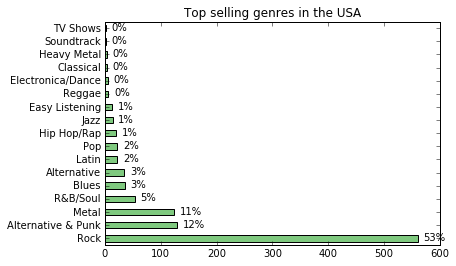

In [11]:
genre_sales_usa = run_query(q)
genre_sales_usa.set_index('genre_name', inplace=True, drop=True)

genre_sales_usa['qty_tracks_sold'].plot.barh(
    title='Top selling genres in the USA'
    , xlim=(0, 600)
    , colormap=plt.cm.Accent
)

plt.ylabel('')


for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "qty_tracks_sold"]
    label = (genre_sales_usa.loc[label, "pct"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))
    
plt.show()

As Rock is the top selling genre, we should pick an artist from this genre

### Performance of Sales Employees

In [16]:
#total dollar amount of sales assigned to each sales support agent
employee_sales = """
WITH employee_sales AS
    (
    SELECT
        i.customer_id
        , c.support_rep_id
        , sum(i.total) customer_total
    FROM invoice i
    INNER JOIN customer c on i.customer_id = c.customer_id
    GROUP BY 1,2
    )
    
SELECT
    e.first_name || " " || e.last_name employee
    , e.city
    , e.hire_date
    , SUM(es.customer_total) sales_total
FROM employee e
INNER JOIN employee_sales es ON e.employee_id = es.support_rep_id
GROUP BY 1;
"""
#invoice: total, customer_id
#customer: customer_id, support_rep_id
#employee: employee_id, firat_name, last_name, city

run_query(employee_sales)

,employee,city,hire_date,sales_total
0,Jane Peacock,Calgary,2017-04-01 00:00:00,1731.51
1,Margaret Park,Calgary,2017-05-03 00:00:00,1584.00
2,Steve Johnson,Calgary,2017-10-17 00:00:00,1393.92


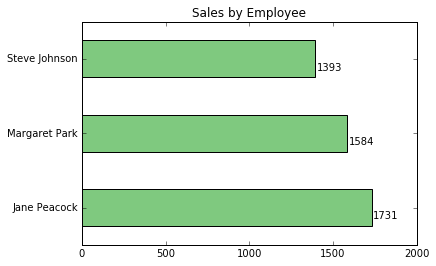

In [18]:
employee_sales_performance = run_query(employee_sales)
employee_sales_performance.set_index('employee', inplace=True, drop=True)

employee_sales_performance['sales_total'].plot.barh(
    title='Sales by Employee'
    , xlim=(0, 2000)
    , colormap=plt.cm.Accent
)

plt.ylabel('')


for i, label in enumerate(list(employee_sales_performance.index)):
    score = employee_sales_performance.loc[label, "sales_total"]
    label = (employee_sales_performance.loc[label, 'sales_total']
            ).astype(int).astype(str)
    plt.annotate(str(label), (score + 10, i - 0.15))
    
plt.show()

While there is a difference between employees sales, there is a corresponding difference in their hired dates.

### Sales by Country

* total number of customers
* total value of sales
* average value of sales per customer
* average order value

In [19]:
#customer: country, customer_id
#invoice: customer_id, total, invoice_id

#any countries with only 1 customer, group as Other
#sort by total sales from highest to lowest with Other at the bottom

sales_by_country = """
WITH country_or_other AS
    (
    SELECT
        CASE
            WHEN(
                SELECT count(*)
                FROM customer
                where country = c.country
            ) = 1 THEN "Other"
            ELSE c.country
        END AS country
        ,c.customer_id
        ,i.total
        ,i.invoice_id
    FROM customer c
    INNER JOIN invoice i ON c.customer_id = i.customer_id
    )
    
    
SELECT
    country
    ,no_customers
    ,total_sales
    ,avg_sales_per_cust
    ,avg_order
FROM
    (
    SELECT
        country
        ,COUNT(DISTINCT customer_id) no_customers
        ,SUM(total) total_sales
        ,SUM(total) / COUNT(DISTINCT customer_id) avg_sales_per_cust
        ,SUM(total) / COUNT(DISTINCT invoice_id) avg_order
        ,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );

"""

run_query(sales_by_country)

,country,no_customers,total_sales,avg_sales_per_cust,avg_order
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


### Visualising

In [21]:
country_sales = run_query(sales_by_country)
country_sales.set_index('country', drop=True, inplace=True)
(1094.94 / country_sales.total_sales.sum()) *100

23.249947445869246

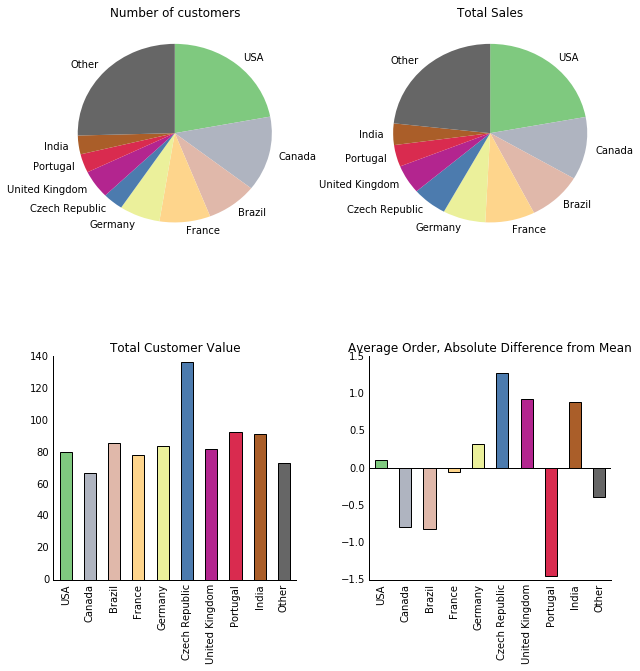

In [52]:
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_sales.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)

#plot 1 (no_customers)
country_sales.no_customers.plot.pie(
    ax = ax1
    ,title="Number of customers"
    ,colormap=plt.cm.Accent
    ,counterclock=False
    ,startangle=90
    ,wedgeprops={'linewidth':0}
)

#plot 2 (total sales)
country_sales.total_sales.plot.pie(
    ax = ax2
    ,title="Total Sales"
    ,colormap=plt.cm.Accent
    ,counterclock=False
    ,startangle=90
    ,wedgeprops={'linewidth':0}
)

#plot 3 (avg sales per customer)
country_sales.avg_sales_per_cust.plot.bar(
    ax = ax3
    ,title="Total Customer Value"
    ,color=colors
)

#plot 4 (Avg Order, Abs difference from Mean)
overall_mean = country_sales.avg_order.mean()
diff_from_avg = country_sales.avg_order - overall_mean
diff_from_avg.plot.bar(
    ax = ax4
    ,title="Average Order, Absolute Difference from Mean"
    ,color=colors
)

ax1.set_ylabel('')

ax2.set_ylabel('')

ax3.set_xlabel('')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.tick_params(top='off', right='off', bottom='off', left='off')

ax4.set_xlabel('')
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)
ax4.tick_params(top='off', right='off', bottom='off', left='off')
ax4.axhline(0, color='black')

plt.show()

The customers we have in the Czech Republic, while small are very high value

### Albums vs Individual Tracks

We will categorize each invoice as an album purchase or not and calculate some summary statistics
* number of invoices
* percentage of invoices

In [53]:
#compare list of tracks on invoice to list of tracks on an album
album_or_not = """
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
"""
run_query(album_or_not)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668
